In [ ]:
import pandas as pd
from pydatagen.functions import ascii_values
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from fastai.vision.all import *


In [ ]:
class TrainingData():
    def __init__(self, df, key_col='key', value_col='value', label_col='label'):
        self.key_col = key_col
        self.value_col = value_col
        self.label_col = label_col
        self._df = df
        
    @classmethod
    def labeled_kv(cls, csv_file_name, key_col, value_col, label_col):
        df = pd.read_csv(csv_file_name)
        return cls(df, key_col=key_col, value_col=value_col, label_col=label_col)
 
    @classmethod
    def unlabeled_table(cls, csv_file_name, key_col, value_col, label_col):
        df = pd.read_csv(csv_file_name)
        if label_col not in df.columns:
            df[label_col] = 0
        
        df = df.melt(id_vars=[label_col]).drop_duplicates()
        return cls(df, key_col='variable', value_col='value', label_col=label_col)
 
    @classmethod
    def concat(cls, training_data_list):
        dflist = [t._df for t in training_data_list]
        new_df = pd.concat(dflist)
        sample_td = training_data_list[0]
        return cls(new_df, key_col=sample_td.key_col, value_col=sample_td.value_col, label_col=sample_td.label_col)
    
    def __len__(self):
        return len(self._df)
 
    def count_by(self, col):
        return self._df.groupby([col]).size()
 
    def add_label(self, key_value, label):
        self._df.loc[self._df[self.key_col] == key_value, self.label_col] = label

    def filter(self, col_name, label):
        return TrainingData(self._df.loc[self._df[col_name] == label],
                            self.key_col, self.value_col, self.label_col)

    def stratified_sample(self, attrs, frac, replace, random_state):
        return TrainingData(self._df.loc[self._df[self.key_col].isin(attrs)].sample(frac=frac, replace=replace, random_state=random_state),
                            self.key_col, self.value_col, self.label_col)

    def vectorize(self, fn):
        """
        Applies the supplied function to the value_col
        """
        return self._df.apply(lambda x: fn(str(x[self.value_col])), axis=1, result_type='expand')
    
    def _vectorize_values(self):
        return self._df.apply(lambda x: ascii_values(str(x[self.value_col]), length=30), axis=1, result_type='expand')
 
    def vectorize_and_split(self, vectorizing_fn, test_size=0.01):
        feature_df = self.vectorize(vectorizing_fn)
        label_df = self._df[self.label_col]
        print(len(feature_df), len(label_df))
        train_x_df, valid_x_df, train_y_df, valid_y_df = train_test_split(feature_df, label_df, test_size=test_size, random_state=42)
        return train_x_df, valid_x_df, train_y_df, valid_y_df
    

Load the data, adding an 'is_phone' column for the label.  Then label all the 'phone' variable rows with 1's. 

In [ ]:
data = TrainingData.unlabeled_table("../datagen/small_phone_number_sample.csv", key_col='variable', value_col='value', label_col='is_phone')
data.add_label('phone', 1)
data.filter('is_phone', 0)._df.head()


,is_phone,variable,value
0,0,locale,ar_AA
10,0,locale,ar_EG
20,0,locale,ar_JO
30,0,locale,ar_PS
40,0,locale,ar_SA


In [ ]:
positives = data.filter('is_phone', 1)

So all the 'phone' variables are now 1's.

Take a look at the breakdown of records for each 'variable' type.

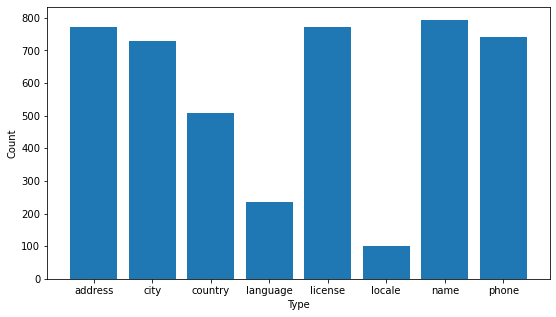

In [ ]:
group_counts = data._df.groupby(['variable']).size()

x_pos = [i for i, _ in enumerate(group_counts)]

plt.figure(figsize=(9, 5))
plt.bar(x_pos, group_counts.values)
plt.ylabel("Count")
plt.xlabel("Type")
plt.xticks(x_pos, group_counts.index)

plt.show()

We have roughly the same number of records for phone (positive examples), as we do for name, license, and address (negative examples).  We'll
create a 50-50 mix of positive to negative examples and draw a stratified sample for the negatives from each of name, license, and address.

Now create the negative examples of roughly the same size.

In [ ]:
negatives = data.stratified_sample(['name', 'address', 'license'], frac=0.33, replace=False, random_state=42)
negatives._df

,is_phone,variable,value
1348,0,name,Rute Skuja
3748,0,license,66A 2654
3731,0,license,SKG 808
1444,0,name,Sérgio Morais
3927,0,license,WAC-577
...,...,...,...
4652,0,address,Maistrova ulica 0a
1124,0,name,Andres Liivak
4263,0,address,647 José María Unions
987,0,name,Mrs. Jodie Roberts


Let's check our negatives count just to be sure.

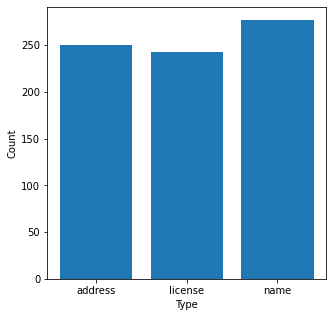

In [ ]:
neg_counts = negatives._df.groupby(['variable']).size()

x_pos = [i for i, _ in enumerate(neg_counts)]

plt.figure(figsize=(5, 5))
plt.bar(x_pos, neg_counts.values)
plt.ylabel("Count")
plt.xlabel("Type")
plt.xticks(x_pos, neg_counts.index)

plt.show()

In [ ]:
len(positives), len(negatives)

(742, 770)

In [ ]:
td = TrainingData.concat([positives, negatives])
td._df.head()

,is_phone,variable,value
2379,1,phone,426.834.4237x982
2380,1,phone,756402-1633
2381,1,phone,577.587.9447
2382,1,phone,001-271-801-4295x8432
2383,1,phone,806.851.4642


In [ ]:
p = partial(ascii_values, length=20, class_boost=['letter', 'number', 'special'], concat=True, multiplier=2)
train_x_df, valid_x_df, train_y_df, valid_y_df = td.vectorize_and_split(p)

1512 1512


In [ ]:
sc = StandardScaler()
sc.fit(train_x_df)

train_x_df = sc.transform(train_x_df)
valid_x_df = sc.transform(valid_x_df)

train_x_tensor = torch.as_tensor(train_x_df).float()
valid_x_tensor = torch.as_tensor(valid_x_df).float()
train_y_tensor = torch.as_tensor(train_y_df.values).float().unsqueeze(1)
valid_y_tensor = torch.as_tensor(valid_y_df.values).float().unsqueeze(1)


In [ ]:
# need this otherwise we can't export our trained models (with fastai)

class PhoneDataset(torch.utils.data.TensorDataset):
    def new_empty(self):
        return PhoneDataset(torch.as_tensor([0]).float(), torch.as_tensor([0]).float())
    

In [ ]:
def phone_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1-predictions, predictions).mean()

def phone_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [ ]:
train_dataset = PhoneDataset(train_x_tensor, train_y_tensor)
valid_dataset = PhoneDataset(valid_x_tensor, valid_y_tensor)

traindl = DataLoader(train_dataset, batch_size=256, shuffle=True)
validdl = DataLoader(valid_dataset, batch_size=256)

dls = DataLoaders(traindl, validdl)

simple_net = nn.Sequential(
    nn.Linear(60, 60),
    nn.ReLU(),
    nn.Linear(60, 60),
    nn.Dropout(p=0.70),
    nn.Linear(60, 1)
)

In [ ]:
torch.manual_seed(42)
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=nn.BCEWithLogitsLoss(reduction='mean'), metrics=phone_accuracy)

In [ ]:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,phone_accuracy,time
0,0.093734,0.000000,1.000000,00:00
1,0.054270,0.000000,1.000000,00:00
2,0.042943,0.000000,1.000000,00:00
3,0.043931,0.000000,1.000000,00:00
4,0.038364,0.000000,1.000000,00:00
5,0.044572,0.000000,1.000000,00:00
6,0.043251,0.000000,1.000000,00:00
7,0.039276,0.000000,1.000000,00:00
8,0.035584,0.000000,1.000000,00:00
9,0.031867,0.000000,1.000000,00:00


In [ ]:
learn.export()

AttributeError: 'list' object has no attribute 'new_empty'

In [ ]:
import fastai
print(fastai.__version__)

2.2.7


In [ ]:
# try with resnet
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=phone_accuracy)
learn.fit_one_cycle(1, 0.1)


AssertionError: `n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`